In [69]:
import json
import urllib3
import time
import urllib.request
import pandas as pd
import numpy
from pandas.io.json import json_normalize
%matplotlib inline
import pickle
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.pad_inches'] = 0
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['legend.frameon'] = True

#pd.set_option('display.max_rows', 50)
#pd.set_option('display.max_columns', 50)

import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('deep')

In [2]:
def requestData(query):
    return json_normalize(json.load(urllib.request.urlopen(query))["data"]["result"])

def queryBuilder(q1):
    url   = 'http://ec2-34-221-15-134.us-west-2.compute.amazonaws.com:8888/api/v1/query?'
    query = 'query='+q1
    return url+query

#query_range?query=up&start=2015-07-01T20:10:30.781Z&end=2015-07-01T20:11:00.781Z&step=15s
def queryRangeBuilder(query,start,end):
    url   = 'http://ec2-34-221-15-134.us-west-2.compute.amazonaws.com:8888/api/v1/query_range?'
    query = 'query='+ query
    start = 'start='+ start + ".000Z"
    end   = 'end='  + end   + ".000Z"
    steps = 'step=60s' 
    return url+query+"&"+start+"&"+end+"&"+steps



In [150]:
def getCPU(start,end):
    cpuUsage = requestData(queryRangeBuilder('100-(avg%20by%20(instance,mode)%20(irate(node_cpu_seconds_total[1m]))*100)',start,end)).explode('values')
    cpuUsage = cpuUsage[cpuUsage['metric.mode'] =='idle'].drop(['metric.mode'],axis=1)
    cpuUsage['time'] = cpuUsage['values'].apply(lambda x: x[0])
    cpuUsage["host_load_average"] = cpuUsage['values'].apply(lambda x: float(x[1]))
    cpuUsage["metric.instance"] = cpuUsage['metric.instance'].apply(lambda x: x.split(":")[0])
    return cpuUsage.groupby(['time','metric.instance']).sum()

def getNetworkIn(start,end):
    Network = requestData(queryRangeBuilder('irate(node_network_receive_bytes_total[1m])',start,end)).drop(["metric.job"],axis=1).explode('values')
    Network = Network[Network['metric.device'] =='eth0'].drop(['metric.device'],axis=1)
    Network['time'] = Network['values'].apply(lambda x: x[0])
    Network["NetworkIn"] = Network['values'].apply(lambda x: float(x[1])/1000000)
    Network["metric.instance"] = Network['metric.instance'].apply(lambda x: x.split(":")[0])
    return Network.groupby(['time','metric.instance']).sum()

def getNetworkOut(start,end):
    Network = requestData(queryRangeBuilder('irate(node_network_transmit_bytes_total[1m])',start,end)).drop(["metric.job"],axis=1).explode('values')
    Network = Network[Network['metric.device'] =='eth0'].drop(['metric.device'],axis=1)
    Network['time'] = Network['values'].apply(lambda x: x[0])
    Network["NetworkOut"] = Network['values'].apply(lambda x: float(x[1])/1000000)
    Network["metric.instance"] = Network['metric.instance'].apply(lambda x: x.split(":")[0])
    return Network.groupby(['time','metric.instance']).sum()

def getMemory(start,end):
    memory = requestData(queryRangeBuilder('jvm_memory_pool_committed_bytes',start,end)).drop(["metric.job","metric.__name__","metric.component"],axis=1).explode('values')
    #memory = memory[memory['metric.pool'] =='shenandoah'].drop(['metric.pool'],axis=1)
    memory['time'] = memory['values'].apply(lambda x: x[0])
    memory["usedMemory"] = memory['values'].apply(lambda x: float(x[1])/1000000000)
    memory["metric.instance"] = memory['metric.instance'].apply(lambda x: x.split(":")[0])
    return memory.groupby(['time','metric.instance']).sum()

def pmdataParser(start,end,field):
    data = requestData(queryRangeBuilder(field,start,end)).drop(["metric.job"],axis=1).explode('values')
    data['time'] = data['values'].apply(lambda x: x[0])
    data[field] = data['values'].apply(lambda x: int(x[1]))
    data["metric.instance"] = data['metric.instance'].apply(lambda x: x.split(":")[0])
    return data.groupby(['time','metric.instance','metric.actor']).sum()

def routerdataParser(start,end,field):
    data = requestData(queryRangeBuilder(field,start,end)).drop(["metric.job","metric.__name__"],axis=1).explode('values')
    data['time'] = data['values'].apply(lambda x: x[0])
    data[field] = data['values'].apply(lambda x: int(x[1]))
    data["metric.instance"] = data['metric.instance'].apply(lambda x: x.split(":")[0])
    return data.groupby(['time','metric.instance','metric.Router']).sum()

start = "2020-08-23T21:53:00"
end   = "2020-08-23T23:30:00"

cpu = getCPU(start,end)
memory = getMemory(start,end)
networkIn = getNetworkIn(start,end)
networkOut = getNetworkOut(start,end)
    
def PartitionManager(start,end):
    updates = pmdataParser(start,end,"Raphtory_Router_Updates_total")
    intra = pmdataParser(start,end,"Raphtory_Intra_Worker_Updates_total")
    inter = pmdataParser(start,end,"Raphtory_Inter_Worker_Updates_total") 
    pm = updates.join(intra).join(inter).join(cpu).join(memory).join(networkIn).join(networkOut).reset_index()
    return pm

    #totalCPU = list(map((lambda x: x/10),sumRows(joinedCPU,"values_x")))
    #totalMessages = list(numpy.diff(list(map((lambda x: x/60),sumRows(joinedCPU,"values_y")))))
    #totalMemory = list(map((lambda x: x/10000000000),sumRows(joinedmemory,"values_x"))) 
    #return(totalCPU,totalMessages,totalMemory)
    
def Router(start,end):
    updates = routerdataParser(start,end,"Raphtory_Router_Output_total")
    return updates.join(cpu).join(memory).join(networkIn).join(networkOut).reset_index()

def Spout(start,end):
    updates = pmdataParser(start,end,"Raphtory_Spout_Tuples_total")
    updates = updates.join(cpu).join(memory).join(networkIn).join(networkOut).reset_index()
    return updates[updates['metric.instance'].str.contains(set(list(updates['metric.instance'])).pop())]


In [151]:
pm =PartitionManager(start,end)
router = Router(start,end)
spout = Spout(start,end)

pmCPU= list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['host_load_average'])
pmMem= list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['usedMemory'])
pmNI= list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['NetworkIn'])
pmNO= list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['NetworkOut'])
pmUpdates= list(numpy.diff(list(map((lambda x: x/60),list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['Raphtory_Router_Updates_total'])))))
pmIntra= list(numpy.diff(list(map((lambda x: x/60),list(pm[pm['metric.actor'].str.contains('PartitionWriter_0')]['Raphtory_Intra_Worker_Updates_total'])))))

routerCPU= list(router['host_load_average'])
routerMem= list(router['usedMemory'])
routerNI= list(router['NetworkIn'])
routerNO= list(router['NetworkOut'])
routerUpdates= list(numpy.diff(list(map((lambda x: x/60),list(router['Raphtory_Router_Output_total'])))))

spoutCPU= list(spout['host_load_average'])
spoutMem= list(spout['usedMemory'])
spoutNI= list(spout['NetworkIn'])
spoutNO= list(spout['NetworkOut'])
spoutUpdates= list(numpy.diff(list(map((lambda x: x/60),list(spout['Raphtory_Spout_Tuples_total'])))))



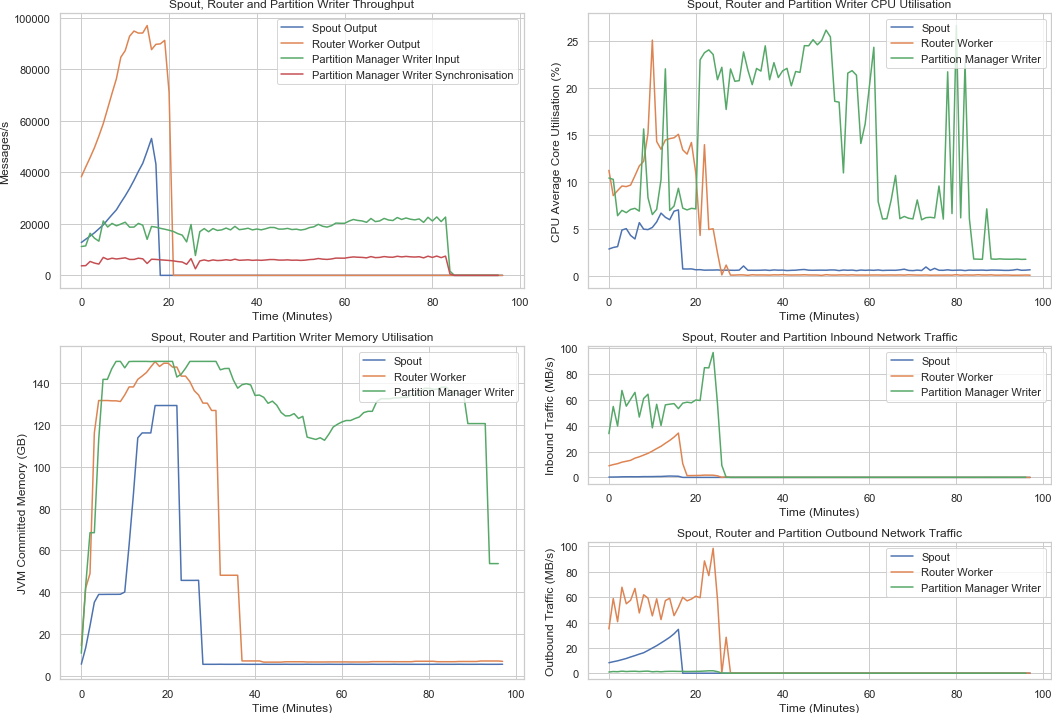

In [152]:
fig = plt.figure(constrained_layout=True,figsize=[14.7, 10])
#fig.suptitle('Exploring which component bottlenecks a Raphtory Deployment', size=20)

spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig, height_ratios=[1.5,0.75,0.75])
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1:, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 1])

plt.setp([ax1], title='Spout, Router and Partition Writer Throughput')
plt.setp([ax1], xlabel='Time (Minutes)')
plt.setp([ax1], ylabel='Messages/s')

ax1.plot(range(0,len(spoutUpdates)),spoutUpdates,label="Spout Output")
ax1.plot(range(0,len(routerUpdates)),routerUpdates,label="Router Worker Output")
ax1.plot(range(0,len(pmUpdates)),pmUpdates,label="Partition Manager Writer Input")
ax1.plot(range(0,len(pmIntra)),pmIntra,label="Partition Manager Writer Synchronisation")
ax1.legend(loc="upper right")

plt.setp([ax2], title='Spout, Router and Partition Writer CPU Utilisation')
plt.setp([ax2], xlabel='Time (Minutes)')
plt.setp([ax2], ylabel='CPU Average Core Utilisation (%)')

ax2.plot(range(0,len(spoutCPU)),spoutCPU,label="Spout")
ax2.plot(range(0,len(routerCPU)),routerCPU,label="Router Worker")
ax2.plot(range(0,len(pmCPU)),pmCPU,label="Partition Manager Writer")
ax2.legend(loc="upper right")

plt.setp([ax3], title='Spout, Router and Partition Writer Memory Utilisation')
plt.setp([ax3], xlabel='Time (Minutes)')
plt.setp([ax3], ylabel='JVM Committed Memory (GB)')

ax3.plot(range(0,len(spoutMem)),spoutMem,label="Spout")
ax3.plot(range(0,len(routerMem)),routerMem,label="Router Worker")
ax3.plot(range(0,len(pmMem)),pmMem,label="Partition Manager Writer")
ax3.legend(loc="upper right")

plt.setp([ax4], title='Spout, Router and Partition Inbound Network Traffic')
plt.setp([ax4], xlabel='Time (Minutes)')
plt.setp([ax4], ylabel='Inbound Traffic (MB/s)')

ax4.plot(range(0,len(spoutNI)),spoutNI,label="Spout")
ax4.plot(range(0,len(routerNI)),routerNI,label="Router Worker")
ax4.plot(range(0,len(pmNI)),pmNI,label="Partition Manager Writer")
ax4.legend(loc="upper right")

plt.setp([ax5], title='Spout, Router and Partition Outbound Network Traffic')
plt.setp([ax5], xlabel='Time (Minutes)')
plt.setp([ax5], ylabel='Outbound Traffic (MB/s)')

ax5.plot(range(0,len(spoutNO)),spoutNO,label="Spout")
ax5.plot(range(0,len(routerNO)),routerNO,label="Router Worker")
ax5.plot(range(0,len(pmNO)),pmNO,label="Partition Manager Writer")
ax5.legend(loc="upper right")
